In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.dates import DayLocator, HourLocator

def butter_lowpass_filter(data, cutoff_period_hours, fs, order):
    """
    Apply a low-pass Butterworth filter to the water depth data.

    Parameters:
    - data: Input signal array (water depth time series)
    - cutoff_period_hours: Period in hours for the cutoff frequency
    - fs: Sampling frequency in Hz (default: 1 Hz for 1-second interval data)
    - order: Order of the filter (default: 5)

    Returns:
    - Filtered signal (low-pass)
    """
    nyq = 0.5 * fs  # Nyquist Frequency
    cutoff_freq = 1 / (cutoff_period_hours * 3600)  # Convert period to frequency (Hz)
    normal_cutoff = cutoff_freq / nyq  # Normalized cutoff frequency

    # Ensure cutoff frequency is within valid range
    if normal_cutoff >= 1:
        raise ValueError("Cutoff frequency is too high. Increase cutoff_period_hours.")

    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)  # Zero-phase filtering

    return filtered_data


def butter_bandpass_filter(data, low_cutoff_period_hours, high_cutoff_period_hours, fs, order=5):
    """
    Apply a bandpass Butterworth filter to the data.
        
    Parameters:
    - data: Input signal array
    - low_cutoff_period_hours: Lower period bound in hours
    - high_cutoff_period_hours: Upper period bound in hours
    - fs: Sampling frequency in Hz
    - order: Order of the filter (default: 5)
        
    Returns:
    - Filtered signal (bandpass)
    """
    nyq = 0.5 * fs
    low_cutoff_freq = 1 / (high_cutoff_period_hours * 3600)  # Convert period to frequency
    high_cutoff_freq = 1 / (low_cutoff_period_hours * 3600)
    low = low_cutoff_freq / nyq
    high = high_cutoff_freq / nyq
        
    if low >= 1 or high >= 1:
        raise ValueError("Cutoff frequency is too high. Increase cutoff period.")
        
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
        
    return filtered_data


def wilmott_skill_score(observed, modeled):
    """
    Calculates the Wilmott Skill Score (WSS) between two datasets.

    The Wilmott Skill Score assesses the accuracy of a modeled dataset
    compared to an observed dataset.  A WSS of 1 indicates perfect
    agreement, while lower values indicate poorer agreement.  It addresses
    some of the shortcomings of simpler metrics like the coefficient of
    determination.

    Args:
        observed (list or numpy.ndarray): The observed values (ground truth).
        modeled (list or numpy.ndarray): The modeled (predicted) values.

    Returns:
        float: The Wilmott Skill Score.

    Raises:
        ValueError: If the input datasets are not of equal length or
                    if either dataset contains only constant values.
        TypeError:  If the input datasets are not lists or numpy arrays.
    """
    # Input validation and error handling
    if not isinstance(observed, (list, np.ndarray)) or not isinstance(modeled, (list, np.ndarray)):
        raise TypeError("Input datasets must be lists or numpy arrays.")

    observed = np.asarray(observed)  # Convert to numpy arrays for easier calculations
    modeled = np.asarray(modeled)

    if observed.size == 0:
        return np.nan #Handle empty arrays

    if observed.shape != modeled.shape:
        raise ValueError("Observed and modeled datasets must have the same length.")

    if np.all(observed == observed[0]) or np.all(modeled == modeled[0]):
        raise ValueError("Cannot calculate WSS if either dataset contains only constant values.")

    # Core calculation of the Wilmott Skill Score
    numerator = np.sum((modeled - observed) ** 2)
    denominator = np.sum((np.abs(modeled - np.mean(observed)) + np.abs(observed - np.mean(observed))) ** 2)
    wss = 1 - (numerator / denominator)

    return wss



#----- CHECK DATA FOR OBSERVATION POINT 1 (TIMU 1) -----#

# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
variable = dataset.variables['waterlevel']


# Read data from the variable
data = variable[:]
first_column = data[:, 0]
first_column = first_column - first_column.mean() # Remove mean to center the data
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)


# Open the validation data
data1 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\RBR Solo3 Data\SaMo2_Side Breakwater\SaMo2_Side_data.csv')
time_data1 = pd.to_datetime(data1["Time"]) # Convert time to datetime format
depth_data1 = data1["Depth"] - 8.78 +0.55 # Convert depth to water level and adding the distance of instrument from the sea bed

# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data1 >= start_date) & (time_data1 <= end_date)
# Apply the mask to the data
filtered_time = time_data1[date_mask]
filtered_depth = depth_data1[date_mask]

# Apply a low-pass filter to the OBSERVED data
filtered_depth = butter_lowpass_filter(filtered_depth, cutoff_period_hours=0.5, fs=1, order=5)
filtered_depth = filtered_depth - filtered_depth.mean() # Remove mean to center the data
# Apply a low-pass filter to the MODELED data
#first_column = butter_lowpass_filter(first_column, cutoff_period_hours=0.01, fs=1, order=5)



# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time, filtered_depth, label='Observed', color='black', linewidth=0.5)
plt.plot(time_values, first_column, label='Modeled',color='red', linewidth=0.5)
plt.title('Water level at Observation Point 1 (Ouside Breakwater)')
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.gca().xaxis.set_major_locator(DayLocator())
plt.gca().xaxis.set_minor_locator(HourLocator(byhour=[0,12]))
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()
# Close the dataset
dataset.close()

# Evaluate the model for Point 1 (Timu 1)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_depth)]
filtered_depth_matched = filtered_depth[matching_indices]

# Ensure the lengths match
first_column_matched = first_column[:len(filtered_depth_matched)]
print("Length of interpolated modeled data: ", len(first_column))
print("Length of filtered observed data: ", len(filtered_depth_matched))

# Compute RMSE, R-squared, Wilmott Skill Score
# rmse = np.sqrt(mean_squared_error(filtered_depth_matched, first_column))
# r2 = r2_score(filtered_depth_matched, first_column)
# wss = wilmott_skill_score(filtered_depth_matched, first_column)
# print("Root Mean Squared Error for Point 1: ", rmse)
# print("R-squared for point 1: ", r2)
# print("Wilmott Skill Score for Point 1: ", wss)


#----- CHECK DATA FOR OBSERVATION POINT 2 (Sarah) -----#

# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
variable = dataset.variables['waterlevel']


# Read data from the variable
data = variable[:]
first_column = data[:, 1]
first_column = first_column - first_column.mean() # Remove mean to center the data
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)




# Open the validation data
data2 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\RBR Solo3 Data\SaMo1_Lee Breakwater\SaMo1_Sarah\SaMo1_Lee_data.csv')
time_data2 = pd.to_datetime(data2["Time"]) # Convert time to datetime format
depth_data2 = data2["Depth"] - 8.516 +0.4 # Convert depth to water level and adding the vertical distance of instrument from the sea bed


# Shift the time of data1 to match the time of data2
time_shift = time_data1.iloc[0] - time_data2.iloc[0]
time_data2  = time_data2  + time_shift

# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data2 >= start_date) & (time_data2 <= end_date)
# Apply the mask to the data
filtered_time2 = time_data2[date_mask]
filtered_depth2 = depth_data2[date_mask]

# Apply a low-pass filter to the OBSERVED data
filtered_depth2 = butter_lowpass_filter(filtered_depth2, cutoff_period_hours=0.5, fs=1, order=5)
filtered_depth2 = filtered_depth2 - filtered_depth2.mean() # Remove mean to center the data
# Apply a low-pass filter to the MODELED data
#first_column = butter_lowpass_filter(first_column, cutoff_period_hours=0.01, fs=1, order=5)


# Define the parameters for the low-pass filter
fs = 1  # Sampling frequency in Hz (1 sample per second)

# Plot the data for point Sarah (inside Breakwater)
plt.plot(filtered_time2, filtered_depth2, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, first_column, label='Modeled',color='red', linewidth=0.5)
plt.title('Water level at Observation Point 2 (Inside Breakwater)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.gca().xaxis.set_major_locator(DayLocator())
plt.gca().xaxis.set_minor_locator(HourLocator(byhour=[0,12]))
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()
# Close the dataset
dataset.close()


# Evaluate the model for Point 2 (Sarah)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time2, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_depth2)]
filtered_depth2_matched = filtered_depth2[matching_indices]

# Ensure the lengths match
first_column_matched = first_column[:len(filtered_depth2_matched)]
print("Length of interpolated modeled data: ", len(first_column))
print("Length of filtered observed data: ", len(filtered_depth2_matched))

# Compute RMSE and R-squared
rmse = np.sqrt(mean_squared_error(filtered_depth2_matched, first_column_matched))
r2 = r2_score(filtered_depth2_matched, first_column)
wss = wilmott_skill_score(filtered_depth2_matched, first_column)
print("Root Mean Squared Error for Point 2: ", rmse)
print("R-squared for point 2: ", r2)
print("Wilmott Skill Score for Point 2: ", wss)




In [11]:
import netCDF4

# Open the NetCDF file
with netCDF4.Dataset(r'G:\My Drive\UCLA\Delft 3D\Backup Output SMBay\Output12\FlowFM_his.nc', 'r') as nc:
    # Get the variable names
    variable_names = nc.variables.keys()

    # Print the variable names
    print(variable_names)


dict_keys(['station_x_coordinate', 'station_y_coordinate', 'station_id', 'station_name', 'waterlevel', 'bedlevel', 'x_velocity', 'y_velocity', 'water_balance_total_volume', 'water_balance_storage', 'water_balance_volume_error', 'water_balance_boundaries_in', 'water_balance_boundaries_out', 'water_balance_boundaries_total', 'water_balance_exchange_with_1D_in', 'water_balance_exchange_with_1D_out', 'water_balance_exchange_with_1D_total', 'water_balance_precipitation', 'water_balance_evaporation', 'water_balance_source_sink', 'water_balance_groundwater_in', 'water_balance_groundwater_out', 'water_balance_groundwater_total', 'water_balance_laterals_in', 'water_balance_laterals_out', 'water_balance_laterals_total', 'time', 'timestep'])


In [ ]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CHECK VELOCITY DATA FOR OBSERVATION POINT 1 SIDE (TIMU 1) CONSIDERING DIRECTION (POSITIVE AND NEGATIVE)-----#
# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
x_velocity =dataset.variables['x_velocity']
y_velocity =dataset.variables['y_velocity']


# Compute the total magnitude of velocity
# Adjust the sign of the velocity based on y_velocity
velocity_signed=np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)*(abs(y_velocity[:])/(y_velocity[:])) 

# Assign the sign of the velocity based on the direction (x_velocity, y_velocity)
# For example, use the arctangent to get the angle and assign sign based on the quadrant
#angle = np.arctan2(y_velocity[:], x_velocity[:])
#velocity_signed = np.abs(np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)) * np.sign(np.sin(angle))


# Read data from the variable
#velocity1 = velocity[:, 0]
velocity_signed = velocity_signed[:, 0]
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)



# Open the validation data
data3 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\ADCP Data\velocity_data_Timu.csv')
time_data3 = pd.to_datetime(data3["Timestamp"]) # Convert time to datetime format
velocity = data3["Velocity Magnitude (m/s)"]

# Assign sign based on "Direction (degrees)" field: 90-270 degrees -> negative, else positive
direction = data3["Direction (degrees)"]
velocity_signed_obs = velocity.copy()
velocity_signed_obs[(direction > 270) | (direction < 90)] *= -1


# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data3 >= start_date) & (time_data3 <= end_date)
# Apply the mask to the data
filtered_time3 = time_data3[date_mask]
filtered_velocity = velocity_signed_obs[date_mask]
filtered_direction = direction[date_mask]

# Apply a low-pass filter to the OBSERVED velocity and direction data

filtered_velocity = butter_bandpass_filter(filtered_velocity, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)
filtered_direction = butter_bandpass_filter(filtered_direction, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)


print("Mean value of filtered_velocity:", np.mean(filtered_velocity))


# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time3, filtered_velocity, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, velocity_signed, label='Modeled Signed', color='blue', linewidth=0.5)
plt.title('Velocity at Observation Point 1 (Outside Breakwater)')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.legend()
plt.show()
# Close the dataset
dataset.close()


# Evaluate the model for Point 1 (Timu 1)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time3, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_velocity)]
filtered_velocity_matched = filtered_velocity[matching_indices]


# Ensure the lengths match
#velocity1_matched = velocity1[:len(filtered_velocity_matched)]
print("Length of interpolated modeled data: ", len(velocity_signed))
print("Length of filtered observed data: ", len(filtered_velocity_matched))

# Compute RMSE,-squared and Wilmott Skill Score
rmse = np.sqrt(mean_squared_error(filtered_velocity_matched, velocity_signed))
r2 = r2_score(filtered_velocity_matched, velocity_signed)
wss = wilmott_skill_score(filtered_velocity_matched, velocity_signed)
print("Root Mean Squared Error for Point 1: ", rmse)
print("R-squared for point 1: ", r2)
print("Wilmott Skill Score for Point 1: ", wss)
print(correlation := np.corrcoef(filtered_velocity_matched, velocity_signed)[0, 1])


Mean value of filtered_velocity: 0.0001951986934550177


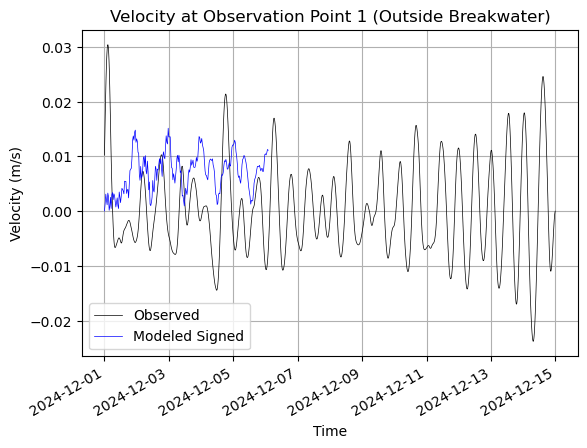

Length of interpolated modeled data:  245
Length of filtered observed data:  245
Root Mean Squared Error for Point 1:  0.01150247077069352
R-squared for point 1:  -1.0110737164617927
Wilmott Skill Score for Point 1:  0.34255735349217553


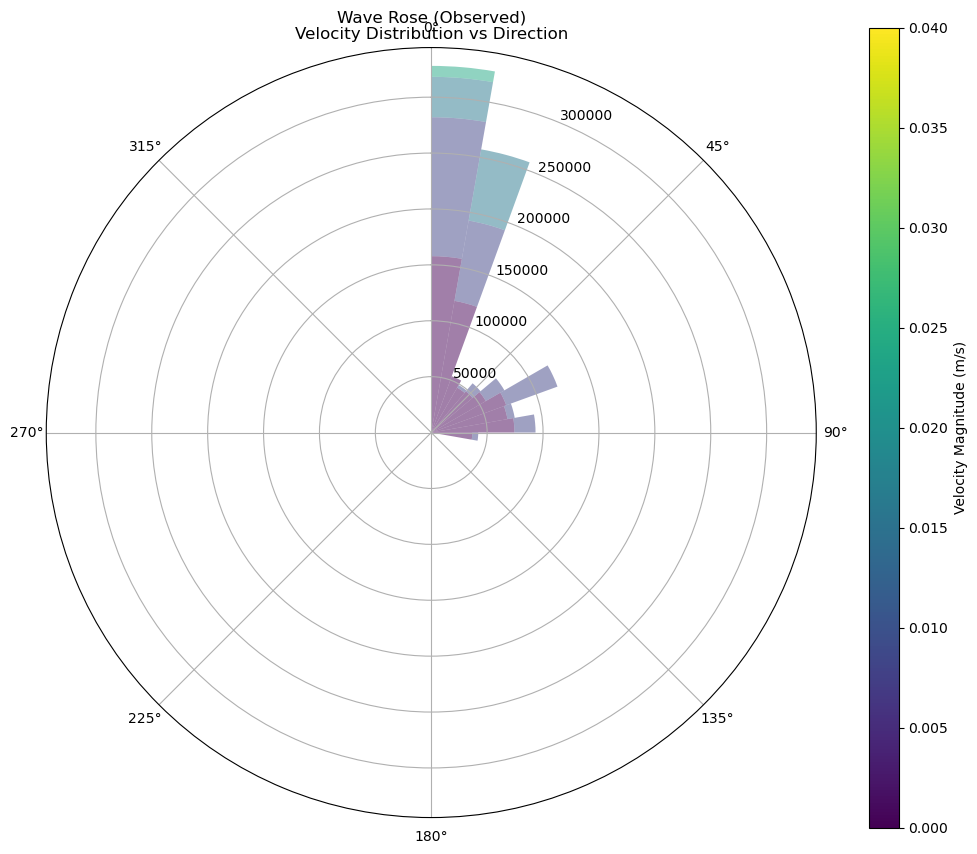

In [7]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CHECK VELOCITY DATA FOR OBSERVATION POINT 1 SIDE (TIMU 1) CONSIDERING ONLY MAGNITUDE (ONLY POSITIVE VALUES)-----#
# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
x_velocity =dataset.variables['x_velocity']
y_velocity =dataset.variables['y_velocity']
# Compute the total magnitude of velocity
# Adjust the sign of the velocity based on y_velocity
velocity=np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)


# Read data from the variable
velocity1 = velocity[:, 0]
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)


# Open the validation data
data3 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\ADCP Data\velocity_data_Timu.csv')
time_data3 = pd.to_datetime(data3["Timestamp"]) # Convert time to datetime format
velocity_obs = data3["Velocity Magnitude (m/s)"]
direction = data3["Direction (degrees)"]


# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data3 >= start_date) & (time_data3 <= end_date)
# Apply the mask to the data
filtered_time3 = time_data3[date_mask]
filtered_velocity = velocity_obs[date_mask]
filtered_direction = direction[date_mask]

# Apply a low-pass filter to the OBSERVED velocity data
filtered_velocity = butter_bandpass_filter(filtered_velocity, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)
filtered_direction = butter_bandpass_filter(filtered_direction, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)

print("Mean value of filtered_velocity:", np.mean(filtered_velocity))

# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time3, filtered_velocity, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, velocity1, label='Modeled Signed', color='blue', linewidth=0.5)
plt.title('Velocity at Observation Point 1 (Outside Breakwater)')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.legend()
plt.show()
# Close the dataset
dataset.close()


# Evaluate the model for Point 1 (Timu 1)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time3, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_velocity)]
filtered_velocity_matched = filtered_velocity[matching_indices]

# Ensure the lengths match
#velocity1_matched = velocity1[:len(filtered_velocity_matched)]
print("Length of interpolated modeled data: ", len(velocity1))
print("Length of filtered observed data: ", len(filtered_velocity_matched))

# Compute RMSE,-squared and Wilmott Skill Score
rmse = np.sqrt(mean_squared_error(filtered_velocity_matched, velocity1))
r2 = r2_score(filtered_velocity_matched, velocity1)
wss = wilmott_skill_score(filtered_velocity_matched, velocity1)
print("Root Mean Squared Error for Point 1: ", rmse)
print("R-squared for point 1: ", r2)
print("Wilmott Skill Score for Point 1: ", wss)


# Create a wave rose with velocity magnitude bins and frequency counts
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Define velocity bins (intervals of 0.01)
velocity_bins = np.arange(0, np.max(filtered_velocity) + 0.01, 0.01)
direction_bins = np.arange(0, 360 + 10, 10)  # 10-degree bins for directions

# Convert direction from degrees to radians
theta = np.deg2rad(filtered_direction)

# Calculate 2D histogram
hist, dir_edges, vel_edges = np.histogram2d(filtered_direction, 
                                          filtered_velocity,
                                          bins=[direction_bins, velocity_bins])

# Get the directions in the middle of the bins
dir_centers = dir_edges[:-1] + np.diff(dir_edges)/2
theta_centers = np.deg2rad(dir_centers)

# Plot each velocity bin as a stacked bar
bottom = np.zeros(len(dir_centers))
for vel_idx in range(len(velocity_bins)-1):
    values = hist[:, vel_idx]
    # Use different colors based on velocity magnitude
    color = plt.cm.viridis(vel_idx / len(velocity_bins))
    ax.bar(theta_centers, values, width=np.deg2rad(10), bottom=bottom,
           color=color, alpha=0.5)
    bottom += values

# Set the zero direction to North and direction of increasing angles to clockwise
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', 
                          norm=plt.Normalize(vmin=velocity_bins[0],
                                          vmax=velocity_bins[-1]))
ax_cbar = plt.axes([0.95, 0.1, 0.03, 0.8])  # [x, y, width, height]
cbar = plt.colorbar(sm, cax=ax_cbar)
cbar.set_label('Velocity Magnitude (m/s)')
ax.set_title('Wave Rose (Observed)\nVelocity Distribution vs Direction')
plt.show()


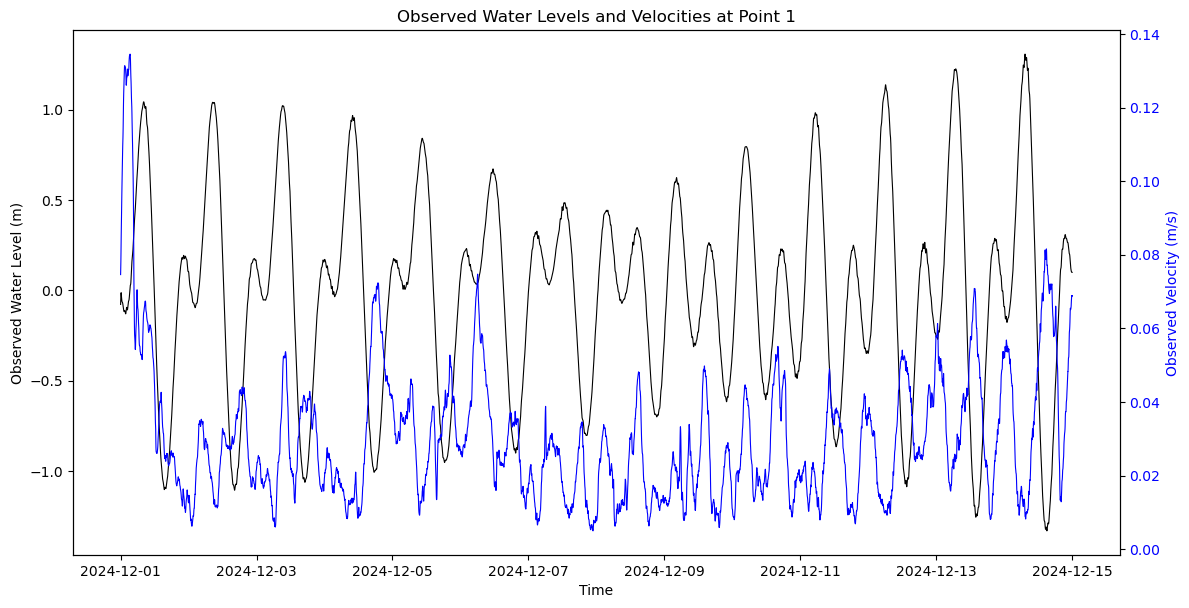

In [5]:
#PLOT OBSERVED WATER LEVELS AND VELOCITIES AT POINT 1 (TIMU 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot observed water levels (filtered_depth) on the left y-axis
color = 'black'
ax1.set_xlabel('Time')
ax1.set_ylabel('Observed Water Level (m)', color=color)
ax1.plot(filtered_time, filtered_depth, color=color, label='Observed Water Level', linewidth=0.8)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for observed velocities (filtered_velocity)
ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('Observed Velocity (m/s)', color=color)
ax2.plot(filtered_time3, filtered_velocity, color=color, label='Observed Velocity', linewidth=0.8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Observed Water Levels and Velocities at Point 1')
plt.show()

Mean value of filtered_velocity: 0.00019536300499197392


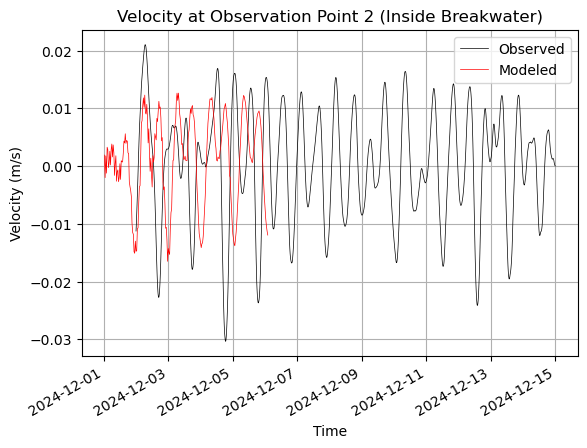

Length of interpolated modeled data:  245
Length of filtered observed data:  245
Root Mean Squared Error for Point 2:  0.015468113887257736
R-squared for point 2:  -0.7994194582517515
Wilmott Skill Score for Point 2:  0.30847926314330043


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# CHECK VELOCITY DATA FOR OBSERVATION POINT 2 (Sarah) -----#
# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
x_velocity = dataset.variables['x_velocity']
y_velocity = dataset.variables['y_velocity']
# Compute the total magnitude of velocity
velocity= np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)
# Compute the total magnitude of velocity
velocity_signed=np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)*(abs(y_velocity[:])/(y_velocity[:])) # Adjust the sign of the velocity based on y_velocity

# Assign the sign of the velocity based on the direction (x_velocity, y_velocity)
# For example, use the arctangent to get the angle and assign sign based on the quadrant
#angle = np.arctan2(y_velocity[:], x_velocity[:])
#velocity_signed = np.abs(np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)) * np.sign(np.sin(angle))


# Read data from the variable
velocity_signed = velocity_signed[:, 1]
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)

# Open the validation data
data3 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\ADCP Data\velocity_data_Sarah.csv')
time_data3 = pd.to_datetime(data3["Timestamp"]) # Convert time to datetime format
velocity = data3["Velocity Magnitude (m/s)"]

# Assign sign based on "Direction (degrees)" field: 137-317 degrees -> negative, else positive
direction = data3["Direction (degrees)"]
velocity_signed_obs = velocity.copy()
velocity_signed_obs[(direction > 270) | (direction < 90)] *= -1

# Create a mask for the desired date range
start_date = np.datetime64('2024-12-02')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data3 >= start_date) & (time_data3 <= end_date)
# Apply the mask to the data
filtered_time3 = time_data3[date_mask]
filtered_velocity = velocity_signed_obs[date_mask]

# Apply a low-pass filter to the OBSERVED velocity data
filtered_velocity = butter_bandpass_filter(filtered_velocity, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)
filtered_direction = butter_bandpass_filter(filtered_direction, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)


print("Mean value of filtered_velocity:", np.mean(filtered_velocity))

# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time3, filtered_velocity, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, velocity_signed, label='Modeled',color='red', linewidth=0.5)
plt.title('Velocity at Observation Point 2 (Inside Breakwater)')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.legend()
plt.show()
# Close the dataset
dataset.close()


# Evaluate the Velocity Results for Point 2 (Sarah)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time3, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_velocity)]
filtered_velocity_matched = filtered_velocity[matching_indices]

# Ensure the lengths match
#velocity1_matched = velocity1[:len(filtered_velocity_matched)]
print("Length of interpolated modeled data: ", len(velocity_signed))
print("Length of filtered observed data: ", len(filtered_velocity_matched))

# Compute RMSE,-squared and Wilmott Skill Score
rmse = np.sqrt(mean_squared_error(filtered_velocity_matched, velocity_signed))
r2 = r2_score(filtered_velocity_matched, velocity_signed)
wss = wilmott_skill_score(filtered_velocity_matched, velocity_signed)
print("Root Mean Squared Error for Point 2: ", rmse)
print("R-squared for point 2: ", r2)
print("Wilmott Skill Score for Point 2: ", wss)

Mean value of filtered_velocity: -3.2627133330460365e-05
Mean value of filtered_direction: 0.21853126652906485


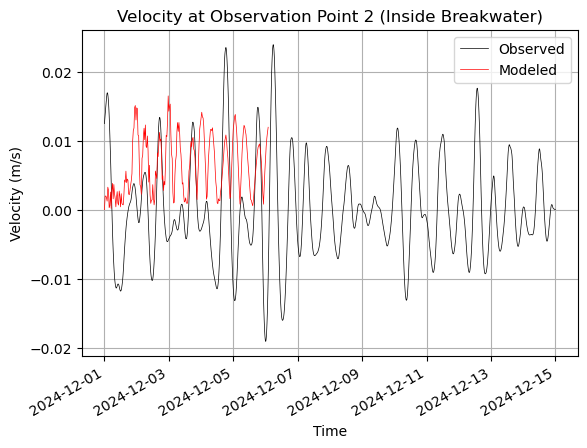

Length of interpolated modeled data:  245
Length of filtered observed data:  245
Root Mean Squared Error for Point 2:  0.011192962301090672
R-squared for point 2:  -0.8081822526985472
Wilmott Skill Score for Point 2:  0.4314182391507223


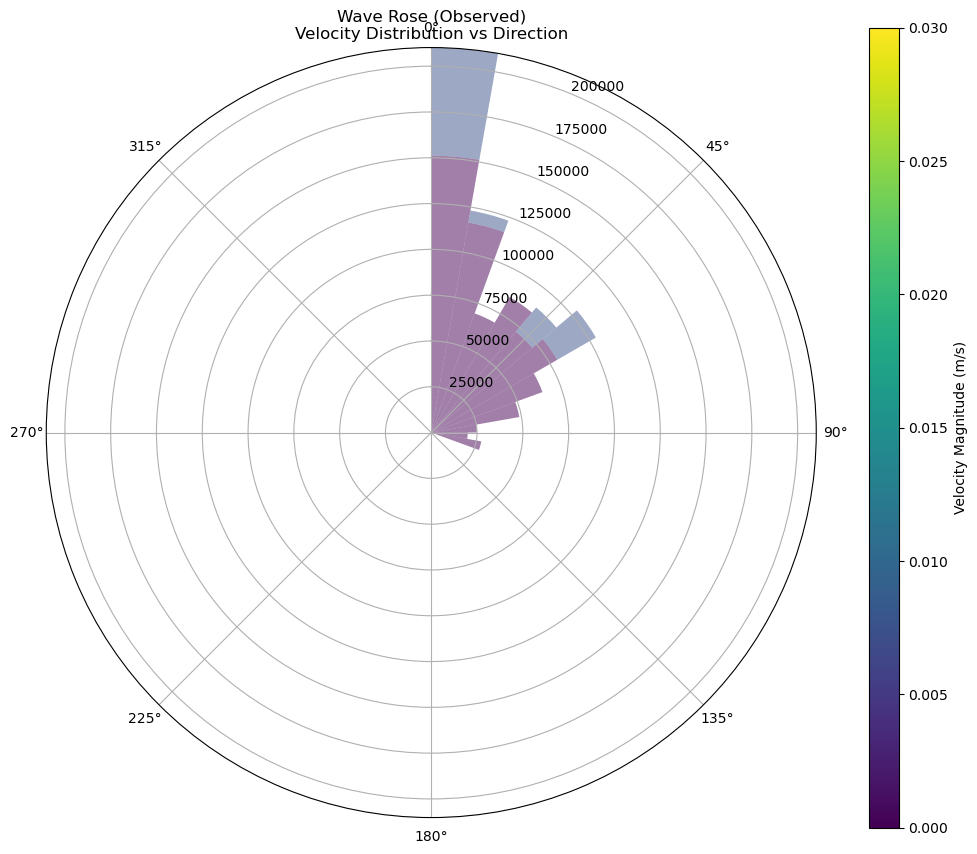

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# CHECK VELOCITY DATA FOR OBSERVATION POINT 2 LEE OF BREAKWATER(Sarah) ONLY MAGINTUDES (Positive Values)-----#
# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
x_velocity = dataset.variables['x_velocity']
y_velocity = dataset.variables['y_velocity']
# Compute the total magnitude of velocity
velocity= np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)


# Read data from the variable
velocity2 = velocity[:, 1]
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)

# Open the validation data
data3 = pd.read_csv(r'H:\My Drive\UCLA\Santa Monica Project\ADCP Deployment 11.20.2024\ADCP Data\velocity_data_Sarah.csv')
time_data3 = pd.to_datetime(data3["Timestamp"]) # Convert time to datetime format
velocity2_obs = data3["Velocity Magnitude (m/s)"]
direction = data3["Direction (degrees)"]


# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data3 >= start_date) & (time_data3 <= end_date)
# Apply the mask to the data
filtered_time3 = time_data3[date_mask]
filtered_velocity = velocity2_obs[date_mask]
filtered_direction = direction[date_mask]

# Apply a low-pass filter to the OBSERVED velocity data
filtered_velocity = butter_bandpass_filter(filtered_velocity, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)
filtered_direction = butter_bandpass_filter(filtered_direction, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=4, order=1)


print("Mean value of filtered_velocity:", np.mean(filtered_velocity))
print("Mean value of filtered_direction:", np.mean(filtered_direction))

# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time3, filtered_velocity, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, velocity2, label='Modeled',color='red', linewidth=0.5)
plt.title('Velocity at Observation Point 2 (Inside Breakwater)')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.legend()
plt.show()
# Close the dataset
dataset.close()


# Evaluate the Velocity Results for Point 2 (Sarah)

# Extract values from filtered_depth2 to match the time points in time_values
# Convert time_values to datetime64 for comparison
time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
matching_indices = np.searchsorted(filtered_time3, time_values_dt64)
matching_indices = matching_indices[matching_indices < len(filtered_velocity)]
filtered_velocity_matched = filtered_velocity[matching_indices]

# Ensure the lengths match
#velocity1_matched = velocity1[:len(filtered_velocity_matched)]
print("Length of interpolated modeled data: ", len(velocity2))
print("Length of filtered observed data: ", len(filtered_velocity_matched))

# Compute RMSE,-squared and Wilmott Skill Score
rmse = np.sqrt(mean_squared_error(filtered_velocity_matched, velocity2))
r2 = r2_score(filtered_velocity_matched, velocity2)
wss = wilmott_skill_score(filtered_velocity_matched, velocity2)
print("Root Mean Squared Error for Point 2: ", rmse)
print("R-squared for point 2: ", r2)
print("Wilmott Skill Score for Point 2: ", wss)

# Create a wave rose with velocity magnitude bins and frequency counts
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Define velocity bins (intervals of 0.01)
velocity_bins = np.arange(0, np.max(filtered_velocity) + 0.01, 0.01)
direction_bins = np.arange(0, 360 + 10, 10)  # 10-degree bins for directions

# Convert direction from degrees to radians
theta = np.deg2rad(filtered_direction)

# Calculate 2D histogram
hist, dir_edges, vel_edges = np.histogram2d(filtered_direction, 
                                          filtered_velocity,
                                          bins=[direction_bins, velocity_bins])

# Get the directions in the middle of the bins
dir_centers = dir_edges[:-1] + np.diff(dir_edges)/2
theta_centers = np.deg2rad(dir_centers)

# Plot each velocity bin as a stacked bar
bottom = np.zeros(len(dir_centers))
for vel_idx in range(len(velocity_bins)-1):
    values = hist[:, vel_idx]
    # Use different colors based on velocity magnitude
    color = plt.cm.viridis(vel_idx / len(velocity_bins))
    ax.bar(theta_centers, values, width=np.deg2rad(10), bottom=bottom,
           color=color, alpha=0.5)
    bottom += values

# Set the zero direction to North and direction of increasing angles to clockwise
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', 
                          norm=plt.Normalize(vmin=velocity_bins[0],
                                          vmax=velocity_bins[-1]))
ax_cbar = plt.axes([0.95, 0.1, 0.03, 0.8])  # [x, y, width, height]
cbar = plt.colorbar(sm, cax=ax_cbar)
cbar.set_label('Velocity Magnitude (m/s)')
ax.set_title('Wave Rose (Observed)\nVelocity Distribution vs Direction')
plt.show()

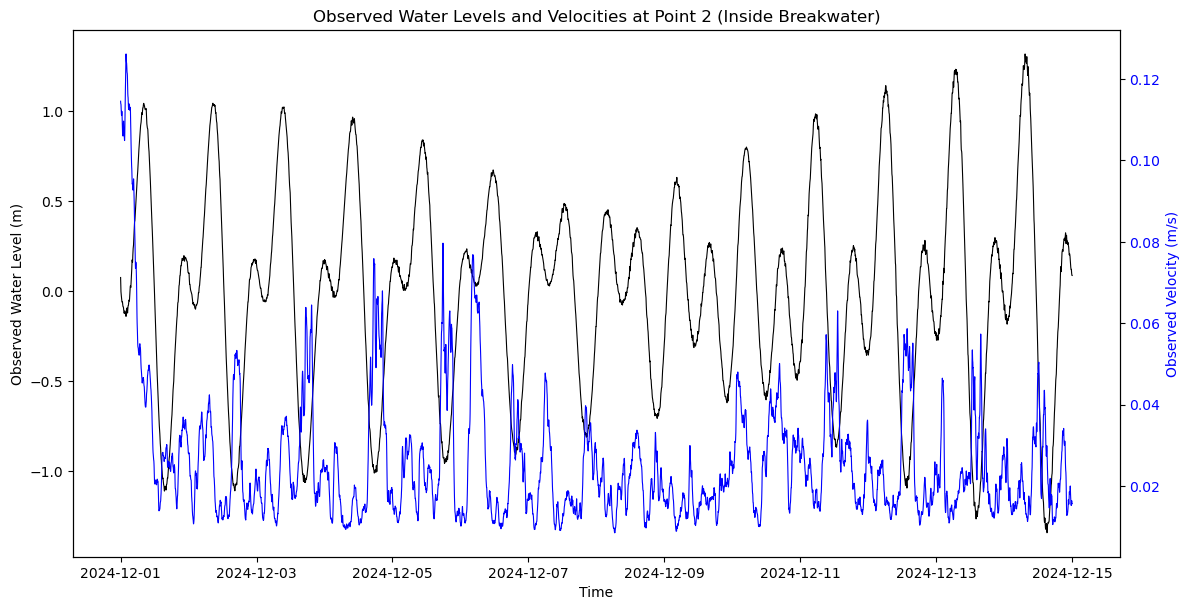

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot observed water levels (filtered_depth2) on the left y-axis
color = 'black'
ax1.set_xlabel('Time')
ax1.set_ylabel('Observed Water Level (m)', color=color)
ax1.plot(filtered_time2, filtered_depth2, color=color, label='Observed Water Level', linewidth=0.8)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for observed velocities (filtered_velocity) at point 2
ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('Observed Velocity (m/s)', color=color)
ax2.plot(filtered_time3, filtered_velocity, color=color, label='Observed Velocity', linewidth=0.8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Observed Water Levels and Velocities at Point 2 (Inside Breakwater)')
plt.show()

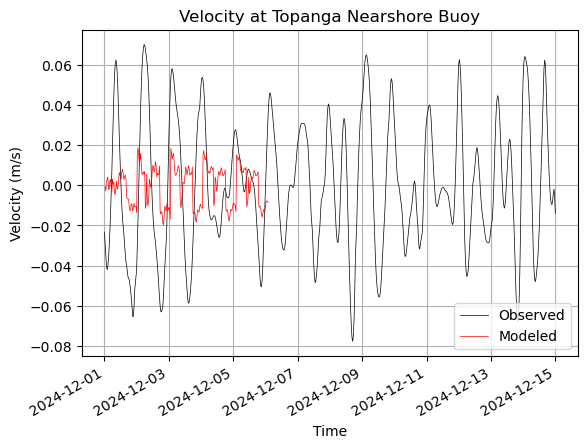

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt


# CHECK VELOCITY DATA FOR OBSERVATION POINT 3 (Topanga Nearshore Buoy) -----#
# Open the NetCDF file
dataset = nc.Dataset(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Results Processing\Test\FlowFM_his.nc')
# Access variables change depending on what variable you want to call
x_velocity = dataset.variables['x_velocity']
y_velocity = dataset.variables['y_velocity']
# Compute the total magnitude of velocity
velocity= np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)
velocity_signed = np.abs(np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)) * (abs(y_velocity[:])/(y_velocity[:])) # Adjust the sign of the velocity based on y_velocity

# Assign the sign of the velocity based on the direction (x_velocity, y_velocity)
# For example, use the arctangent to get the angle and assign sign based on the quadrant
#angle = np.arctan2(y_velocity[:], x_velocity[:])
#velocity_signed = np.abs(np.sqrt(x_velocity[:]**2 + y_velocity[:]**2)) * np.sign(np.sin(angle))


# Read data from the variable
velocity3 = velocity[:, 14]
velocity_signed = velocity_signed[:, 14]
time_units = dataset.variables['time'].units
time = dataset.variables['time'][:]
time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
time_values = nc.num2date(time[:], units=time_units, calendar=time_calendar)

# Open the validation data
data3 = pd.read_csv(r'H:\My Drive\UCLA\Delft 3D\Santa Monica\Validation Data\TopangaNearshoreBuoy.csv')
time_data3 = pd.to_datetime(data3["Datetime"]) # Convert time to datetime format
velocity = data3["Cspd"]
levels = data3["Hs"]

# Assign sign based on "Direction (degrees)" field: 90-270 degrees -> negative, else positive
direction = data3["Cdir"]
velocity_signed_obs = velocity.copy()
velocity_signed_obs[(direction > 270) | (direction < 90)] *= -1

# Create a mask for the desired date range
start_date = np.datetime64('2024-12-01')
end_date = np.datetime64('2024-12-15')
date_mask = (time_data3 >= start_date) & (time_data3 <= end_date)
# Apply the mask to the data
filtered_time3 = time_data3[date_mask]
filtered_velocity = velocity_signed_obs[date_mask]

# Apply a low-pass filter to the OBSERVED velocity data
filtered_velocity = butter_bandpass_filter(filtered_velocity, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=1/1800, order=1)
filtered_levels = butter_bandpass_filter(levels, low_cutoff_period_hours=10, high_cutoff_period_hours=26, fs=1/1800, order=1)

# Plot the data for point Timu 1 (ouside Breakwater)
plt.plot(filtered_time3, filtered_velocity, label='Observed',color='black', linewidth=0.5)
plt.plot(time_values, velocity_signed, label='Modeled',color='red', linewidth=0.5)
plt.title('Velocity at Topanga Nearshore Buoy')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels for better readability
plt.legend()
plt.show()
# Close the dataset
#dataset.close()


# # Evaluate the Velocity Results for Point 2 (Sarah)

# # Extract values from filtered_depth2 to match the time points in time_values
# # Convert time_values to datetime64 for comparison
# time_values_dt64 = np.array(time_values, dtype='datetime64[s]')
# matching_indices = np.searchsorted(filtered_time3, time_values_dt64)
# matching_indices = matching_indices[matching_indices < len(filtered_velocity)]
# filtered_velocity_matched = filtered_velocity[matching_indices]

# # Ensure the lengths match
# #velocity1_matched = velocity1[:len(filtered_velocity_matched)]
# print("Length of interpolated modeled data: ", len(velocity2))
# print("Length of filtered observed data: ", len(filtered_velocity_matched))

# # Compute RMSE,-squared and Wilmott Skill Score
# rmse = np.sqrt(mean_squared_error(filtered_velocity_matched, velocity2))
# r2 = r2_score(filtered_velocity_matched, velocity2)
# wss = wilmott_skill_score(filtered_velocity_matched, velocity2)
# print("Root Mean Squared Error for Point 2: ", rmse)
# print("R-squared for point 2: ", r2)
# print("Wilmott Skill Score for Point 2: ", wss)